## Solving the CartPole problem with Deep Q Networks and Experience Replay:

Improvements:
1. Use fitted Q networks
2. Improve plotting, add tqdm loss bar
3. Add render of the environment

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from IPython.display import clear_output
import random

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
env = gym.envs.make('CartPole-v1')

In [3]:
# plotting inspired from https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb

def plot_vals(vals):
    clear_output(wait=True)
    ax = plt.subplot()
    ax.plot(vals, label='scores')
    ax.axhline(195, c='red',ls='--', label='goal')
    ax.set_ylabel('Reward')
    ax.set_xlabel('Episodes')
    plt.title('Random Policy')
    plt.legend()
    plt.grid()
    plt.show()

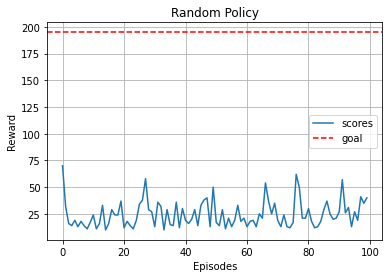

In [4]:
# Testing a random policy
def random_policy(eps=100):
    vals = []
    for _ in range(eps):
        tot = 0
        done = False
        state = env.reset()
        while not done:
            next_state, reward, done, _ = env.step(env.action_space.sample())
            tot += reward
        vals.append(tot)
    plot_vals(vals)
    
random_policy()

In [7]:
class DQN(object):
    ''' Deep Q Network implentation using Keras.
    '''
    def __init__(self, num_actions, input_shape=4):
        self.num_actions = num_actions
        self.model = Sequential()
        self.model.add(Dense(64, input_shape=(input_shape, ), kernel_initializer='RandomNormal'))
        self.model.add(LeakyReLU())
        self.model.add(Dense(128, kernel_initializer='RandomNormal'))
        self.model.add(LeakyReLU())
        self.model.add(Dense(128, kernel_initializer='RandomNormal'))
        self.model.add(LeakyReLU())        
        self.model.add(Dense(self.num_actions, kernel_initializer='RandomNormal'))     
        opt = Adam(learning_rate=0.001)
        self.model.compile(optimizer=opt, loss='mean_squared_error')
            
    def predict(self, state):
        return self.model.predict(state.reshape(1, -1))
    
    def update(self, state, target):
        self.model.fit(state.reshape(1, -1), target.reshape(1, -1), epochs=1, verbose=False)
        
    def epsilon_greedy_policy(self, state, epsilon):
        probs = np.ones(self.num_actions) * epsilon / self.num_actions
        q_vals = self.predict(state)[0]
        probs[np.argmax(q_vals)] += 1 - epsilon
        return probs
        
    def plot_report(self, lengths, rewards):
        clear_output(wait=True)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
        fig.suptitle('Deep Q Network')
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Length')
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Reward')
        ax[1].axhline(195, c='red',ls='--', label='goal')        
        ax[0].plot(lengths)        
        ax[1].plot(rewards, label='reward')
        ax[0].grid()
        ax[1].grid()
        ax[1].legend()
        plt.show()
        
    def update_mem(self, memory, discount_factor, rep_size):
        if len(memory) >= rep_size:
            mem = random.sample(memory, rep_size)
            xs = np.array([s[0] for s in mem])
            ys = np.array([self.predict(s[0])[0] for s in mem])
            for y in range(len(ys)):
                if not mem[y][4]:
                    ys[y][mem[y][1]] = mem[y][2] + discount_factor * np.max(self.predict(mem[y][3])[0])
                else:
                    ys[y][mem[y][1]] = mem[y][2]
            hist = self.model.fit(xs, ys, epochs=1, verbose=False)
            return round(hist.history['loss'][0], 3)
    
    def solve(self, env, num_episodes=100, epsilon=0.2, rep_size=32,
              discount_factor=0.9, eps_decay=0.99, plot=False):
        lengths, rewards = [], []
        memory = []
        #tr = tqdm.trange(num_episodes, desc='MSE ', leave=True)
        for ep in range(num_episodes):#tr:
            state = env.reset()
            done = False
            tot_r, length = 0, 0
            while not done:
                #probs = self.epsilon_greedy_policy(state, epsilon)
                #action = np.random.choice(np.arange(self.num_actions), p=probs)

                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(self.predict(state)[0])
                
                next_state, reward, done, _ = env.step(action)
                memory.append((state, action, reward, next_state, done))

                loss = self.update_mem(memory, discount_factor, rep_size)
                #if loss:
                #    tr.set_description(f"MSE Loss - {loss}")
                #    tr.refresh()  
        
                tot_r += reward
                length += 1
                state = next_state
            
            epsilon = max(0.01, epsilon * eps_decay)            
            lengths.append(length)
            rewards.append(tot_r)
            if plot:
                self.plot_report(lengths, rewards)
    
    def test(self, eps=100):
        vals = []
        for _ in (range(eps)):
            tot = 0
            done = False
            state = env.reset()
            while not done:
                #env.render()
                # full greedy policy
                next_state, reward, done, _ = env.step(np.argmax(solver.predict(state)))
                tot += reward
                state = next_state
            vals.append(tot)
        plot_vals(vals)                

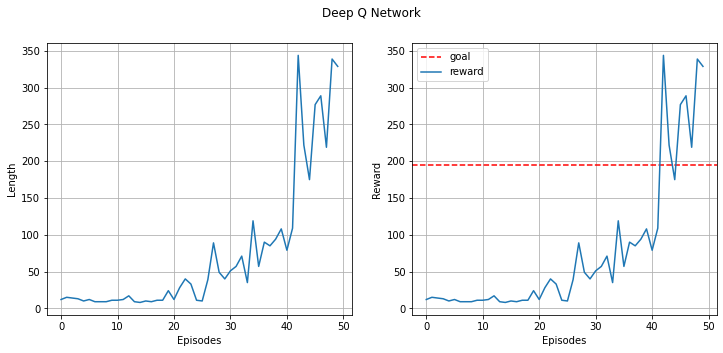

In [8]:
solver = DQN(num_actions=2)
solver.solve(env, num_episodes=50, plot=True)